# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try the TTM-1024-96 model.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm/TTM).

## Installation

In [1]:
cd ../..

/Users/iimtiaz/Library/CloudStorage/OneDrive-keystonestrategy.com/Documents/Repositories/keystone/granite-tsfm


In [4]:
# Clone the ibm/tsfm
#! git clone https://github.com/IBM/tsfm.git

In [5]:
# Install the tsfm library
#! pip install ".[notebooks]"

ERROR: Directory '.[notebooks]' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
# Change directory. Move inside the tsfm repo.
%cd tsfm_public

/Users/iimtiaz/Library/CloudStorage/OneDrive-keystonestrategy.com/Documents/Repositories/keystone/granite-tsfm/tsfm_public


In [3]:
# Do ls
! ls

__init__.py _version.py models      toolkit     version.py


## Imports

In [31]:
# Standard
import os
import math
import tempfile
import torch
import matplotlib.pyplot as plt


# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# First Party
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
    plot_preds,
)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback



## Important arguments

In [10]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "iqvia"
#DATA_ROOT_PATH = "~/SageMaker/granite-tsfm/iqvia_zip.csv"
DATA_ROOT_PATH = "/Users/iimtiaz/Library/CloudStorage/OneDrive-keystonestrategy.com/Documents/IQVIA/IQVIA for Keystone - National Totals Report/IQVIA for Keystone - 3115185 - GLP1 National Totals Report.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 1.0

## Data processing pipeline

In [14]:
dataset_path = DATA_ROOT_PATH
timestamp_column = "date"
id_columns = ["zip3","product_name"]
target_columns = ["total_claims"]
split_config = {
                "train": 0.7,
                "test": 0.2
            }
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=["month_id"],
    delimiter="|"
)

data = data.dropna()

data['date'] = pd.to_datetime(data['month_id'].astype(str), format='%Y%m')

data = data.sort_values(by=['zip3', 'date'])

data = data.groupby(['zip3','product_name','date']).sum()

# filter on xip codes that have at least 10 data points
#data = data.groupby('zip3').filter(lambda x: len(x)>10)
data.reset_index(inplace=True)

data = data[['zip3','product_name','date','total_claims']]
data

/var/folders/85/gzcbjmp964z7t818sc2j6fmr0000gn/T/ipykernel_41759/279564953.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(


,zip3,product_name,date,total_claims
0,0,ADLYXIN,2023-05-01,2
1,0,ADLYXIN STARTER PACK,2023-03-01,2
2,0,BYDUREON,2023-02-01,1
3,0,BYDUREON,2023-08-01,2
4,0,BYDUREON,2024-04-01,1
...,...,...,...,...
383730,999,ZEPBOUND,2023-12-01,9
383731,999,ZEPBOUND,2024-01-01,20
383732,999,ZEPBOUND,2024-02-01,37
383733,999,ZEPBOUND,2024-03-01,43


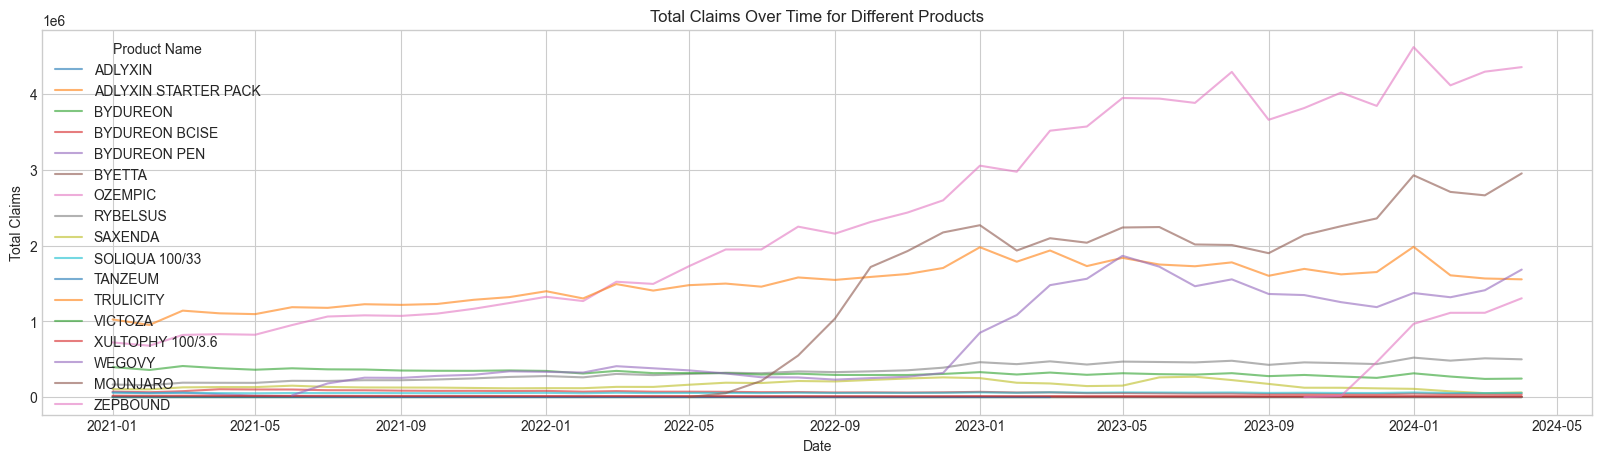

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume data is already prepared as described
subset_data = data#data.iloc[:30000]
subset_data = subset_data.groupby(['date','product_name']).sum()
subset_data.reset_index(inplace=True)
# Create a scatter plot for each product_name on the same figure
plt.figure(figsize=(20, 5))

# Iterate over each product_name and plot it
for product in subset_data['product_name'].unique():
    product_data = subset_data[subset_data['product_name'] == product]
    plt.plot(product_data['date'], product_data['total_claims'], label=product, alpha=0.6)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Total Claims")
plt.title("Total Claims Over Time for Different Products")
plt.legend(title="Product Name")
plt.show()

<Axes: xlabel='date'>

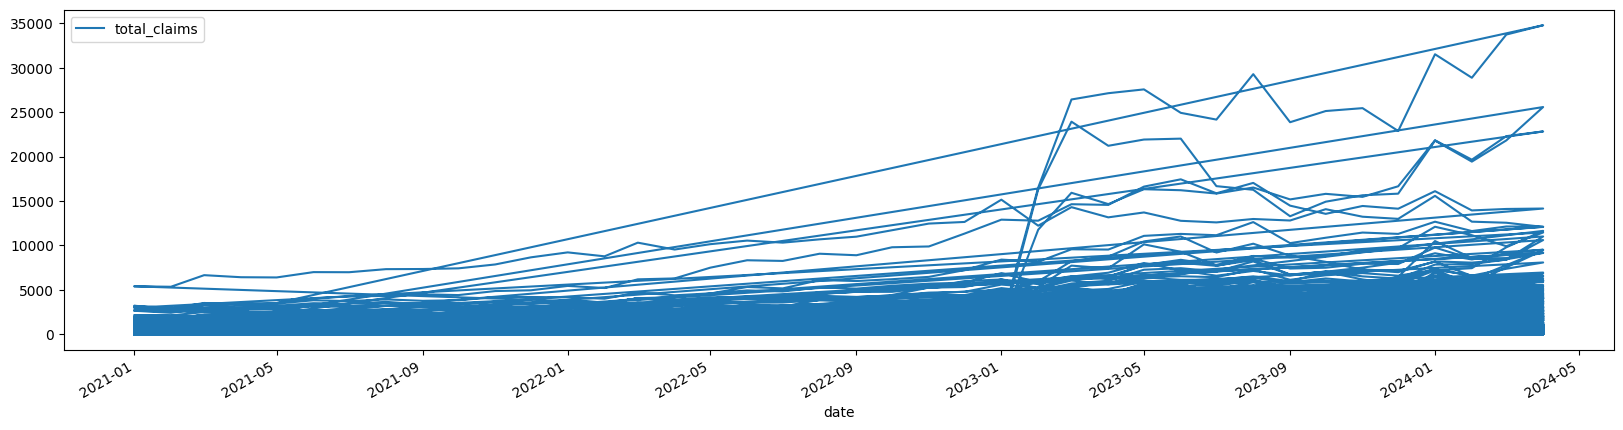

In [15]:
data.iloc[:30000].plot(x="date", y="total_claims", figsize=(20,5))

In [16]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

# Get all unique dates
unique_dates = data[timestamp_column].unique()

# Get unique values for all id columns
unique_keys = [data[col].unique() for col in id_columns]

# Create a full grid of all combinations of dates and keys
full_grid = pd.MultiIndex.from_product([unique_dates] + unique_keys, names=[timestamp_column] + id_columns).to_frame(index=False)

# Merge with original data
data_full = pd.merge(full_grid, data, on=[timestamp_column] + id_columns, how='left')

# Fill missing values in the target column(s)
for target_column in target_columns:
    data_full[target_column].fillna(0, inplace=True)  # Or use np.nan or another default value

# Debugging: Print the first few rows of the full dataset to check
print(data_full.head())

#print(data)
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=True,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data_full, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

/var/folders/85/gzcbjmp964z7t818sc2j6fmr0000gn/T/ipykernel_41759/2208278032.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_full[target_column].fillna(0, inplace=True)  # Or use np.nan or another default value
/var/folders/85/gzcbjmp964z7t818sc2j6fmr0000gn/T/ipykernel_41759/2208278032.py:39: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


        date  zip3          product_name  total_claims
0 2023-05-01     0               ADLYXIN           2.0
1 2023-05-01     0  ADLYXIN STARTER PACK           0.0
2 2023-05-01     0              BYDUREON           0.0
3 2023-05-01     0        BYDUREON BCISE         455.0
4 2023-05-01     0          BYDUREON PEN           5.0
Data lengths: train = 16473, val = 16473, test = 16473


In [17]:
import numpy as np
import torch

def compute_mape(y_true, y_pred, epsilon=1e-10):
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def compute_mase(y_true, y_pred, y_train, m=1, epsilon=1e-10):
    mae_forecast = np.mean(np.abs(y_true - y_pred))
    naive_forecast_errors = np.abs(y_train[m:] - y_train[:-m])
    mae_naive = np.mean(naive_forecast_errors)
    mase = mae_forecast / (mae_naive + epsilon)
    return mase

def calculate_metrics(trainer, dset, train_dset, channel=-1, m=1):
    device = torch.cuda.current_device() if torch.cuda.is_available() else torch.device("cpu")
    
    # Prepare the data
    all_past_values = torch.stack([dset[i]["past_values"] for i in range(len(dset))])
    all_future_values = torch.stack([dset[i]["future_values"] for i in range(len(dset))])
    train_past_values = torch.stack([train_dset[i]["past_values"] for i in range(len(train_dset))])
    
    trainer.model = trainer.model.to(device)
    trainer.model.eval()
    
    # Make predictions
    with torch.no_grad():
        output = trainer.model(all_past_values.to(device))
    
    y_hat = output.prediction_outputs[:, :, channel].detach().cpu().numpy()
    pred_len = y_hat.shape[1]
    
    all_y_true = all_future_values[:, :pred_len, channel].detach().cpu().numpy()
    y_train = train_past_values[:, :, channel].detach().cpu().numpy().flatten()
    
    mape_list = []
    mase_list = []

    for i in range(len(dset)):
        y_true = all_y_true[i].flatten()
        y_pred = y_hat[i].flatten()
        
        # Ensure they are on the same scale
        assert y_true.shape == y_pred.shape, f"Shapes do not match: {y_true.shape} vs {y_pred.shape}"
        
        # Compute MAPE for the current sample
        mape = compute_mape(y_true, y_pred)
        mape_list.append(mape)
        
        # Compute MASE for the current sample
        mase = compute_mase(y_true, y_pred, y_train, m)
        mase_list.append(mase)
    
    mean_mape = np.mean(mape_list)
    mean_mase = np.mean(mase_list)

    print(f"Mean MAPE: {mean_mape:.2f}%")
    print(f"Mean MASE: {mean_mase:.4f}")


## Zero-shot evaluation method

In [18]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION)
#zeroshot_model

In [19]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    )
)

In [20]:
zeroshot_trainer.evaluate(test_dataset)

  0%|          | 0/258 [00:00<?, ?it/s]

{'eval_loss': 0.4684523344039917,
 'eval_model_preparation_time': 0.0009,
 'eval_runtime': 4.3828,
 'eval_samples_per_second': 3758.565,
 'eval_steps_per_second': 58.867}

In [21]:
calculate_metrics(zeroshot_trainer, test_dataset, train_dataset, channel=-1, m=1)

Mean MAPE: 7816753895.27%
Mean MASE: 2910463526.0960


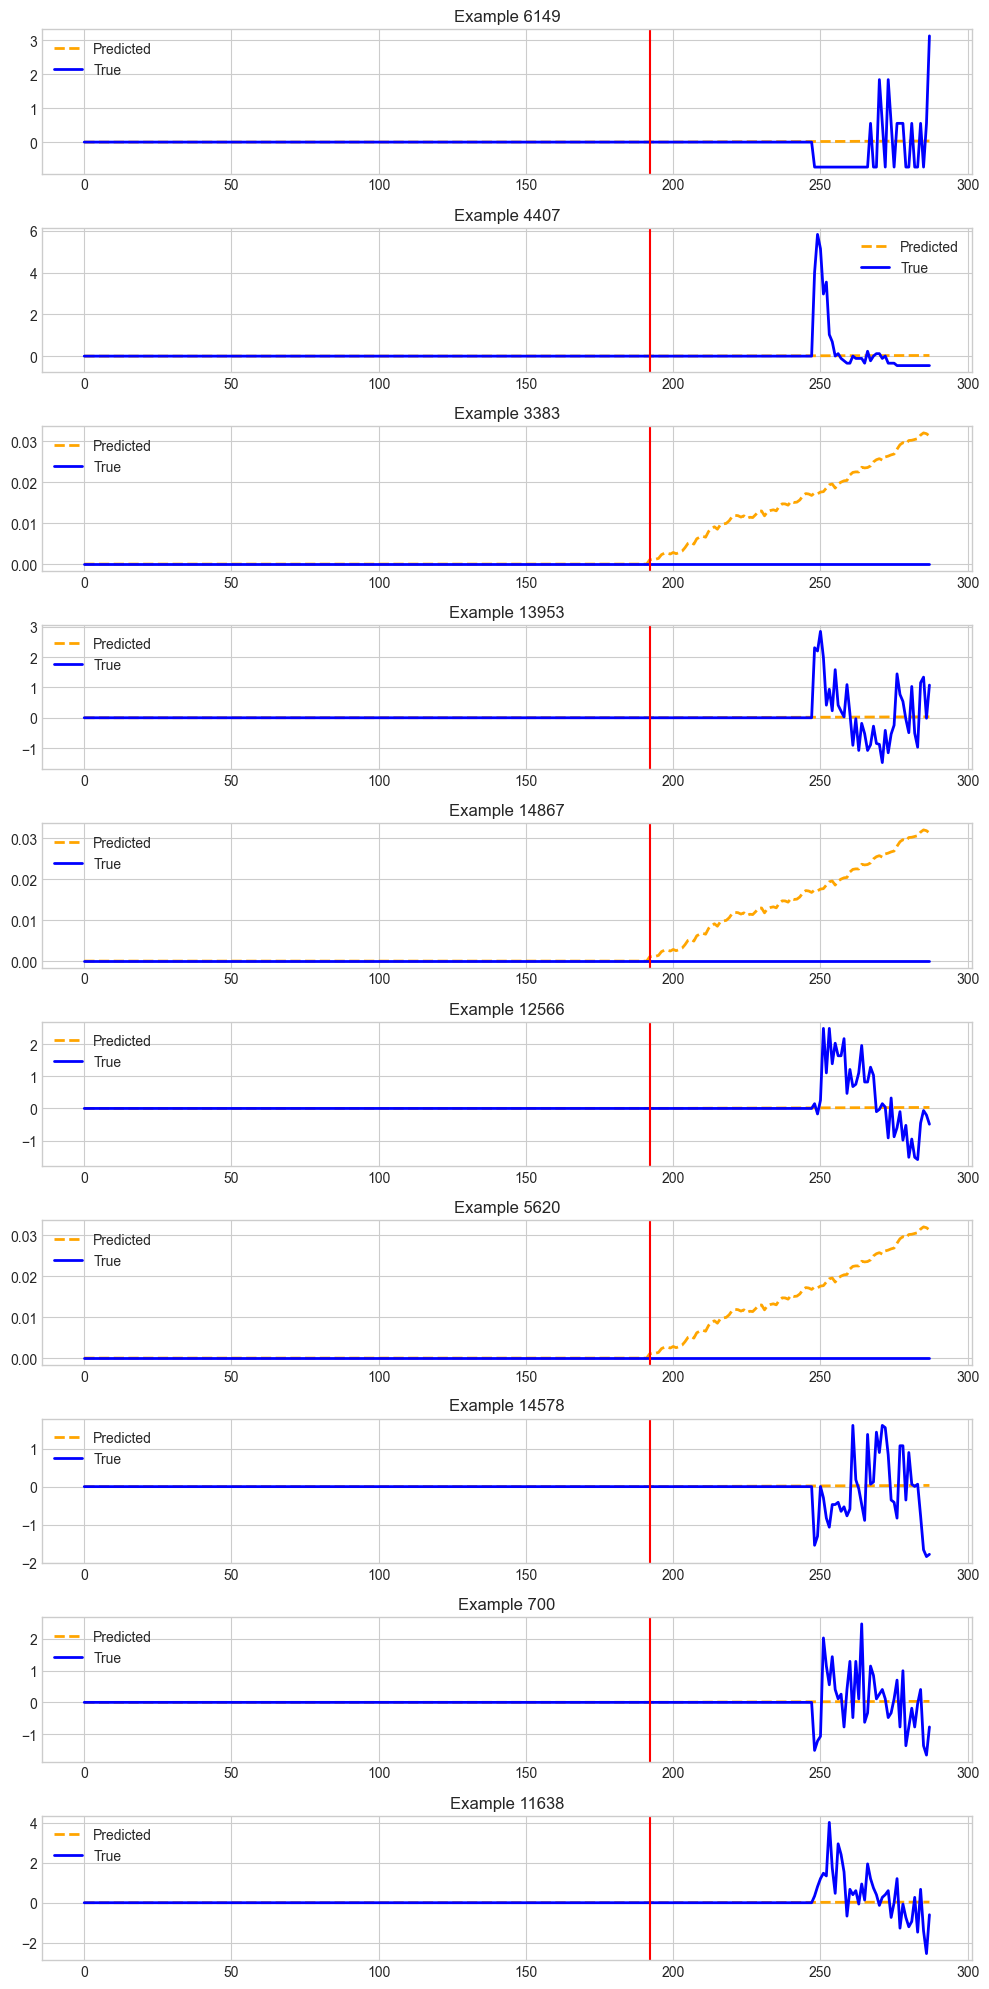

In [22]:
# plot
plot_preds(trainer=zeroshot_trainer, dset=test_dataset, plot_dir=os.path.join(OUT_DIR, "iqvia"), plot_prefix="test_zeroshot", channel=0)

 ## Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [23]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION, head_dropout=0.7)
#finetune_forecast_model

### Frezze the TTM backbone

In [24]:
print(
        "Number of params before freezing backbone",
        count_parameters(finetune_forecast_model),
    )

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


### Finetune few-shot 5%

In [25]:
# Important parameters
learning_rate = 0.001
num_epochs = 20 # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 8

In [26]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


/opt/anaconda3/envs/ttm/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/41200 [00:00<?, ?it/s]

{'loss': 0.2233, 'grad_norm': 0.06587953865528107, 'learning_rate': 0.00010431797434567417, 'epoch': 1.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.3170810341835022, 'eval_runtime': 103.8109, 'eval_samples_per_second': 158.683, 'eval_steps_per_second': 19.844, 'epoch': 1.0}
{'loss': 0.2176, 'grad_norm': 0.05978187918663025, 'learning_rate': 0.0002800352231163184, 'epoch': 2.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.31451019644737244, 'eval_runtime': 102.7119, 'eval_samples_per_second': 160.381, 'eval_steps_per_second': 20.056, 'epoch': 2.0}
{'loss': 0.217, 'grad_norm': 0.04987920820713043, 'learning_rate': 0.0005200610067347545, 'epoch': 3.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.3143707513809204, 'eval_runtime': 103.976, 'eval_samples_per_second': 158.431, 'eval_steps_per_second': 19.812, 'epoch': 3.0}
{'loss': 0.2171, 'grad_norm': 0.03346918150782585, 'learning_rate': 0.0007600704410631871, 'epoch': 4.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.31428754329681396, 'eval_runtime': 102.9373, 'eval_samples_per_second': 160.03, 'eval_steps_per_second': 20.012, 'epoch': 4.0}
{'loss': 0.217, 'grad_norm': 0.02471281960606575, 'learning_rate': 0.0009357430234355499, 'epoch': 5.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.3144401013851166, 'eval_runtime': 102.5313, 'eval_samples_per_second': 160.663, 'eval_steps_per_second': 20.091, 'epoch': 5.0}
{'loss': 0.2171, 'grad_norm': 0.06582363694906235, 'learning_rate': 0.0009999999970334785, 'epoch': 6.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.3144416809082031, 'eval_runtime': 103.5721, 'eval_samples_per_second': 159.049, 'eval_steps_per_second': 19.89, 'epoch': 6.0}
{'loss': 0.217, 'grad_norm': 0.01780509389936924, 'learning_rate': 0.0009874518835902776, 'epoch': 7.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.3140924572944641, 'eval_runtime': 105.1076, 'eval_samples_per_second': 156.725, 'eval_steps_per_second': 19.599, 'epoch': 7.0}
{'loss': 0.2171, 'grad_norm': 0.0758298933506012, 'learning_rate': 0.0009504609975704062, 'epoch': 8.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.314627468585968, 'eval_runtime': 103.9129, 'eval_samples_per_second': 158.527, 'eval_steps_per_second': 19.824, 'epoch': 8.0}
{'loss': 0.2172, 'grad_norm': 0.07718268036842346, 'learning_rate': 0.0008908822164593889, 'epoch': 9.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.31470420956611633, 'eval_runtime': 103.6751, 'eval_samples_per_second': 158.891, 'eval_steps_per_second': 19.87, 'epoch': 9.0}
{'loss': 0.2171, 'grad_norm': 0.08126767724752426, 'learning_rate': 0.0008117030691214565, 'epoch': 10.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.3149261772632599, 'eval_runtime': 105.7915, 'eval_samples_per_second': 155.712, 'eval_steps_per_second': 19.472, 'epoch': 10.0}
{'loss': 0.217, 'grad_norm': 0.04240582510828972, 'learning_rate': 0.0007168939286274589, 'epoch': 11.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.3142145574092865, 'eval_runtime': 104.651, 'eval_samples_per_second': 157.409, 'eval_steps_per_second': 19.684, 'epoch': 11.0}
{'loss': 0.2168, 'grad_norm': 0.022778188809752464, 'learning_rate': 0.0006112089211702585, 'epoch': 12.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.3144008219242096, 'eval_runtime': 104.3485, 'eval_samples_per_second': 157.865, 'eval_steps_per_second': 19.742, 'epoch': 12.0}
{'loss': 0.217, 'grad_norm': 0.07671835273504257, 'learning_rate': 0.0004999475343259186, 'epoch': 13.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.31429409980773926, 'eval_runtime': 105.6791, 'eval_samples_per_second': 155.878, 'eval_steps_per_second': 19.493, 'epoch': 13.0}
{'loss': 0.2168, 'grad_norm': 0.01840101182460785, 'learning_rate': 0.00038868887861790634, 'epoch': 14.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.31428828835487366, 'eval_runtime': 104.5056, 'eval_samples_per_second': 157.628, 'eval_steps_per_second': 19.712, 'epoch': 14.0}
{'loss': 0.2168, 'grad_norm': 0.03268349915742874, 'learning_rate': 0.00028301192761910816, 'epoch': 15.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.3143302798271179, 'eval_runtime': 105.6193, 'eval_samples_per_second': 155.966, 'eval_steps_per_second': 19.504, 'epoch': 15.0}
{'loss': 0.2167, 'grad_norm': 0.02005419321358204, 'learning_rate': 0.00018821576492112222, 'epoch': 16.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.31436488032341003, 'eval_runtime': 109.2311, 'eval_samples_per_second': 150.809, 'eval_steps_per_second': 18.859, 'epoch': 16.0}
{'loss': 0.2168, 'grad_norm': 0.0877305120229721, 'learning_rate': 0.00010905386595592898, 'epoch': 17.0}


  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.31433913111686707, 'eval_runtime': 106.9644, 'eval_samples_per_second': 154.005, 'eval_steps_per_second': 19.259, 'epoch': 17.0}
{'train_runtime': 4042.1875, 'train_samples_per_second': 81.505, 'train_steps_per_second': 10.193, 'train_loss': 0.21738522288324083, 'epoch': 17.0}
[TrackingCallback] Mean Epoch Time = 133.05198104241316 seconds, Total Train Time = 4042.1856100559235


TrainOutput(global_step=35020, training_loss=0.21738522288324083, metrics={'train_runtime': 4042.1875, 'train_samples_per_second': 81.505, 'train_steps_per_second': 10.193, 'total_flos': 692771071426560.0, 'train_loss': 0.21738522288324083, 'epoch': 17.0})

In [27]:
finetune_forecast_trainer.evaluate(test_dataset)

  0%|          | 0/2060 [00:00<?, ?it/s]

{'eval_loss': 0.45813682675361633,
 'eval_runtime': 104.7806,
 'eval_samples_per_second': 157.214,
 'eval_steps_per_second': 19.66,
 'epoch': 17.0}

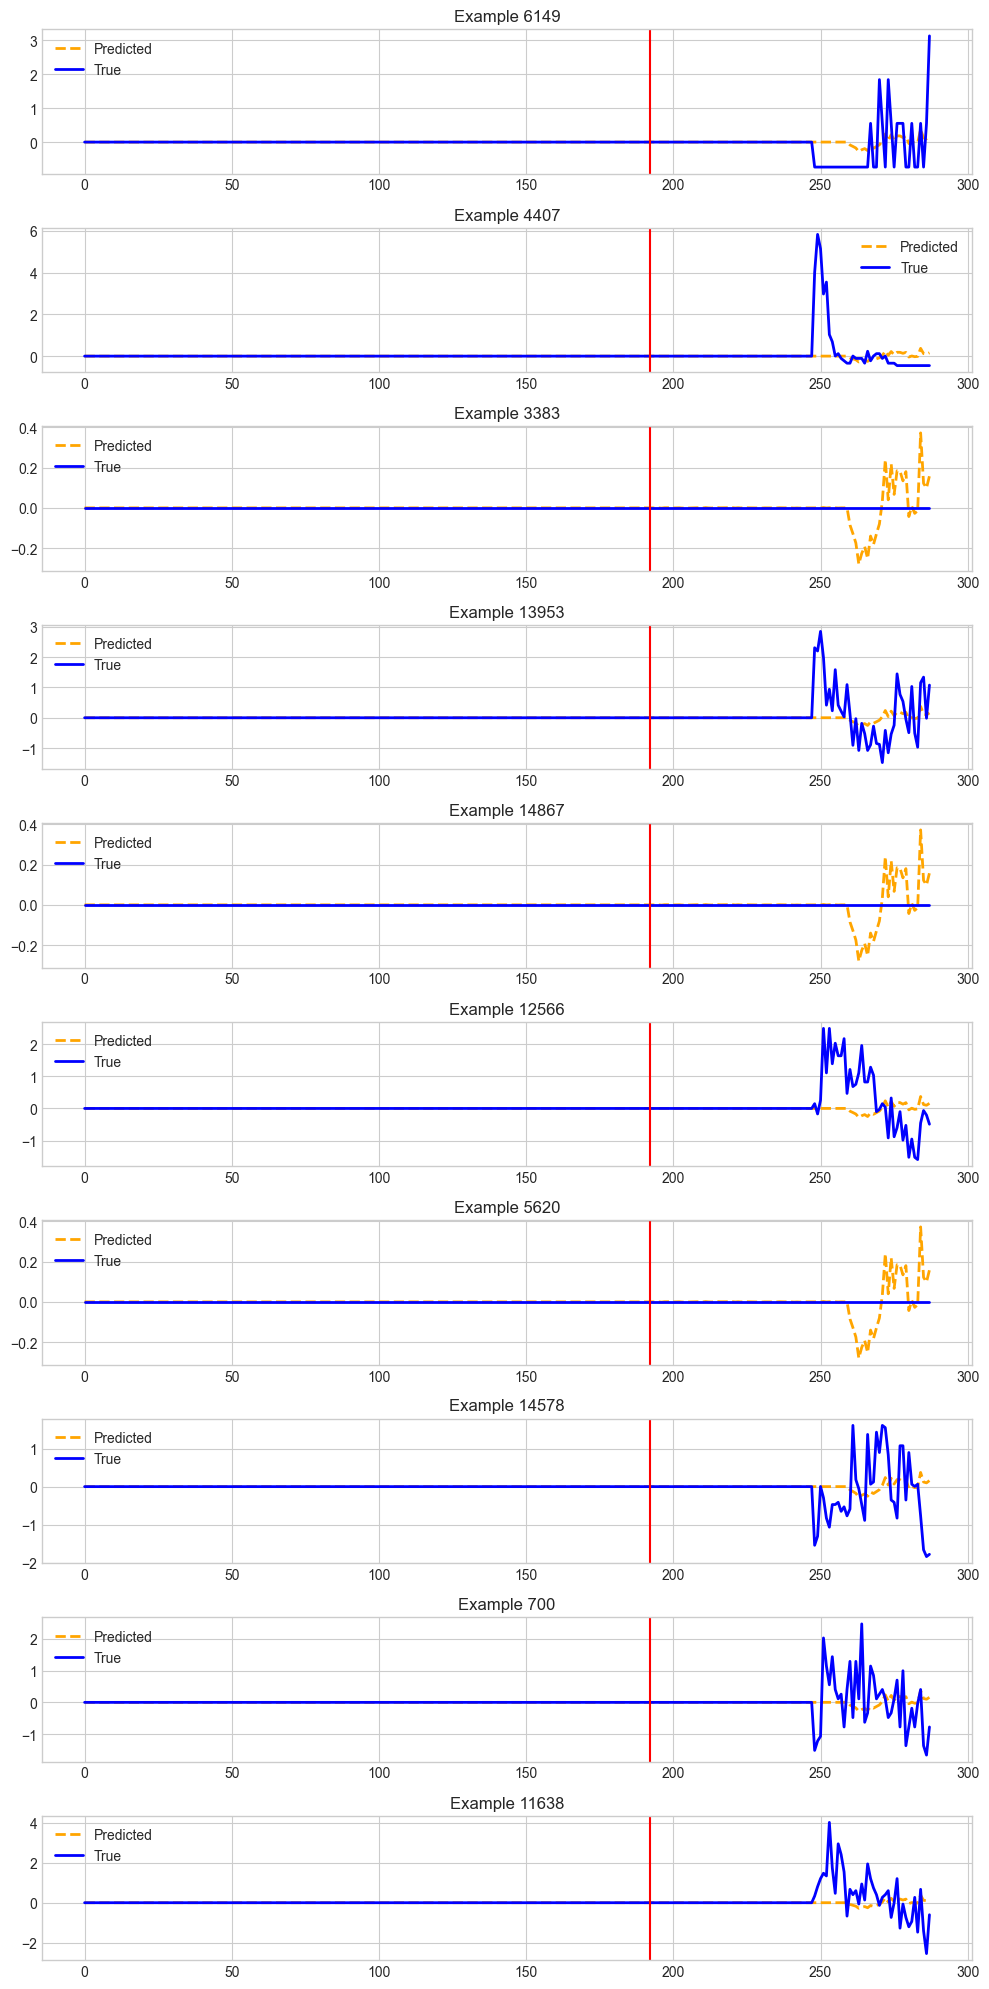

In [28]:
plot_preds(trainer=finetune_forecast_trainer, dset=test_dataset, plot_dir=os.path.join(OUT_DIR, "iqvia"), plot_prefix="test_fewshot", channel=0)

In [29]:
calculate_metrics(finetune_forecast_trainer, test_dataset, train_dataset, channel=-1, m=1)

Mean MAPE: 9847069814.24%
Mean MASE: 2850801907.3147


## Hands-on Questions

### Q 15.	Zero-shot on etth1. 
In your notebook, modify the zero-shot code to try it on etth1 dataset. Etth1 is available on https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv. 
Use the following train/val/test splits:
```
split_config = {
                "train": [0, 12 * 30 * 24],
                "valid": [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24],
                "test": [
                    12 * 30 * 24 + 4 * 30 * 24,
                    12 * 30 * 24 + 8 * 30 * 24,
                ],
            }
```

### Q 16.	Zero-shot on etth1 by truncating the length
Let’s say your application needs to forecast 24 hours in the future. You can still use the 512-96 TTM model and set `prediction_filter_length=24` argument during model loading. Try it on etth1, and note the evaluation error (on all channels)?

### Q 17.	Few-shot on etth1
Try few-shot 5% forecasting on etth1. Freeze the backbone and fine-tune for only 1 epoch. What is the evaluation error you get?

### Q 18.	Few-shot on etth1 by changing loss function
Try few-shot 5% forecasting on etth1 by changing the `loss` to `mae` (mean absolute error). Freeze the backbone and fine-tune for only 1 epoch. What is the evaluation error you get?

### Q 19.	Zero-shot on channel 0 and 2 for etth1
In your notebook, add `prediction_channel_indices=[0,2]` during model loading to forecast only 0th and 2nd channels. In this case, execute the following code and note the output shape.
```
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION, prediction_channel_indices=[0,2])
output = zeroshot_model.forward(test_dataset[0]['past_values'].unsqueeze(0), return_loss=False)
output.prediction_outputs.shape
```